In [1]:
import re
import gc
import os
import time
import datetime
import collections
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten, Activation, Conv1D, LSTM
from keras.layers.advanced_activations import PReLU
from keras.initializers import Constant
from keras.initializers import he_normal, he_uniform
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
# seems to reduce the chance of gpu errors, also doesn't blindly allocate all vram 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [9]:
def log_specgram(audio, sample_rate, eps=1e-10):
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=240,
                                    noverlap=120,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def list_wavs_fname(dirpath, ext='wav'):
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+\\(\w+)\\\w+\.wav$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+\\(\w+\.wav)$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [10]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.\\data'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [42]:
labels, fnames = list_wavs_fname(train_data_path)
np.random.seed(0)

new_sample_rate = 16000
y = []
x = []
xu=[]
yu=[]
x_val = []
y_val = []
t0 = datetime.datetime.now()
i = 1

for label, fname in zip(labels, fnames):
    if label not in legal_labels and label != '_background_noise_':
        continue
    if i%100 == 0:
        delta = datetime.datetime.now() - t0
        clear_output(wait=True)
        print('%.2f%% %.1f seconds left' % (i/647.27, delta.total_seconds()*(64727/i-1)))
    i+=1
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        if False: 
        #if fname[0] == '0' or fname[0] == '1' or label == '_background_noise_' and np.random.randint(5) == 0:
            y_val.append(label)
            x_val.append(specgram)
        else:
            y.append(label)
            x.append(specgram)
        
x_mean = np.array(x).mean()
x_std = np.array(x).std()

        
#for u in range(10):
for u in range(1):
    xu.append(x.copy())
    yu.append(y.copy())
    np.random.seed(0)
    for label, fname in zip(labels, fnames):
        if i%100 == 0:
            delta = datetime.datetime.now() - t0
            clear_output(wait=True)
            print('%.2f%% %.1f seconds left' % (i/647.27, delta.total_seconds()*(64727/i-1)))
        if label not in legal_labels and label != '_background_noise_' and np.random.randint(10) == u:
            i+=1
            sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
            samples = pad_audio(samples)
            if len(samples) > 16000:
                n_samples = chop_audio(samples)
            else: n_samples = [samples]
            for samples in n_samples:
                resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
                _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
                if False: 
                #if fname[0] == '0' or fname[0] == '1':
                    y_val.append(label)
                    x_val.append(specgram)
                else:
                    yu[u].append(label)
                    xu[u].append(specgram)

    xu[u] = np.array(xu[u])
    xu[u] = (xu[u] - x_mean) / x_std
    yu[u] = label_transform(yu[u])
    label_index = yu[u].columns.values
    yu[u] = yu[u].values
    yu[u] = np.array(yu[u])

# x_val = np.array(x_val)
# x_val = (x_val - x_mean) / x_std
# y_val = label_transform(y_val)
# y_val = y_val.values
# y_val = np.array(y_val)

# x = np.array(x)
# y = label_transform(y)
# label_index = y.columns.values
# y = y.values
# y = np.array(y)
# x_mean = x.mean()
# x_std = x.std()
# x = (x - x_mean) / x_std
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
del x, y
gc.collect()

42.80% 193.6 seconds left


250882

In [44]:
collections.Counter(label_index[np.argmax(yu[0], axis=1)])

Counter({'down': 2359,
         'go': 2372,
         'left': 2353,
         'no': 2375,
         'off': 2357,
         'on': 2367,
         'right': 2367,
         'stop': 2380,
         'up': 2375,
         'yes': 2377,
         'silence': 120,
         'unknown': 4072})

In [ ]:
np.random.seed(0)
def little_boy():
    i = Input(shape=(99, 161))
    x = Dropout(0.2)(i)
    x = Conv1D(filters=256, kernel_size=19, strides=8, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
        
    x = LSTM(256, unroll=True,
             dropout=0.4, recurrent_dropout=0.5, 
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    o = Dense(12, activation='softmax')(x)
    
    return Model(inputs=i, outputs=o)

model = little_boy()
model.summary()

In [26]:
models = []
for u in range(10):
    models.append(little_boy())
    
histories = []    
opt = Nadam(lr=1e-3, epsilon=1e-4)
def step_scheduler(epoch, lr):
    return 2e-3 - 1e-5*epoch

for u in range(10):
    models[u].compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])
    histories.append(models[u].fit(
        xu[u], yu[u],
        workers=2,
        batch_size=512, epochs=200,
        #validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[LearningRateScheduler(step_scheduler, verbose=0)]))
    clear_output(wait=True)
    print(str(u+1)+'/10')

10/10


In [ ]:
opt = Nadam(lr=1e-3, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    return 2e-3 - 1e-5*epoch

history = model.fit(x_train, y_train,
                    workers=2,
                    batch_size=512, epochs=200,
                    validation_data=(x_test, y_test),
                    verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

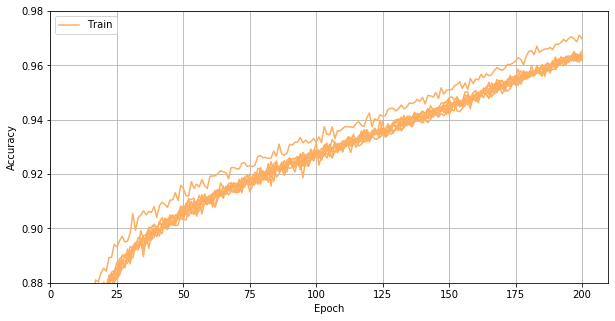

In [33]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
for u in range(10):
    y1 = histories[u].history['accuracy']# + history2.history['accuracy']
    #y2 = histories[u].history['val_accuracy']# + history2.history['val_accuracy']

    #xs = np.linspace(1, 400, 1000)
    #y1s = UnivariateSpline(x, y1, s=0.002)(xs)
    #y2s = UnivariateSpline(x, y2, s=0.03)(xs)

    #plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
    #plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
    #plt.plot(x, acc, color='#abd9e9')
    #plt.plot(x, val, color='#2c7bb6')
    plt.plot(x, y1, color='#fdae61')
    #plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

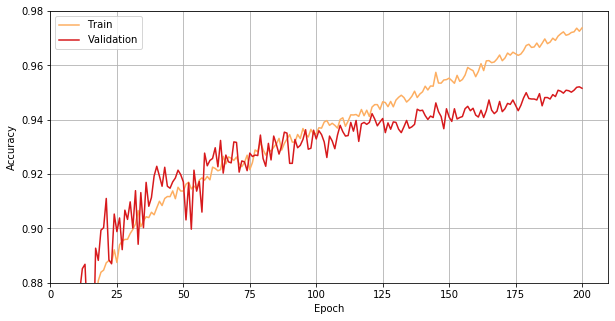

In [20]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

In [45]:
from keras.layers.advanced_activations import ELU

def big_boy():
    i = Input(shape=(132, 121))
    x = Dropout(0.1)(i)
    
    x = Conv1D(filters=256, kernel_size=6, strides=2, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=512, kernel_size=6, strides=2, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
        
    x = LSTM(512, unroll=True,
             dropout=0.4, recurrent_dropout=0.5,
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)

    x = Dense(units=512, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    o = Dense(units=12, activation='softmax')(x)
    
    return Model(inputs=i, outputs=o)

model = big_boy()
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 132, 121)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 132, 121)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 64, 256)           186112    
_________________________________________________________________
elu_58 (ELU)                 (None, 64, 256)           0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 64, 256)           1024      
_________________________________________________________________
dropout_74 (Dropout)         (None, 64, 256)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 30, 512)           786

In [46]:
opt = Nadam(lr=.01, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    if epoch < 2:
        return lr/2
    return 2e-3 - 1e-5*epoch


history = model.fit(xu[0], yu[0],
                    batch_size=256, epochs=200,
                    #validation_data=(x_val, y_val),
                    verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

Epoch 1/200
 - 17s - loss: 5.8406 - accuracy: 0.3775
Epoch 2/200
 - 14s - loss: 1.7615 - accuracy: 0.7209
Epoch 3/200
 - 14s - loss: 1.3270 - accuracy: 0.7985
Epoch 4/200
 - 14s - loss: 1.1605 - accuracy: 0.8282
Epoch 5/200
 - 14s - loss: 1.0673 - accuracy: 0.8509
Epoch 6/200
 - 14s - loss: 1.0157 - accuracy: 0.8612
Epoch 7/200
 - 14s - loss: 0.9729 - accuracy: 0.8721
Epoch 8/200
 - 14s - loss: 0.9395 - accuracy: 0.8809
Epoch 9/200
 - 14s - loss: 0.9147 - accuracy: 0.8854
Epoch 10/200
 - 14s - loss: 0.8953 - accuracy: 0.8916
Epoch 11/200
 - 14s - loss: 0.8885 - accuracy: 0.8960
Epoch 12/200
 - 14s - loss: 0.8612 - accuracy: 0.8987
Epoch 13/200
 - 14s - loss: 0.8613 - accuracy: 0.8999
Epoch 14/200
 - 14s - loss: 0.8458 - accuracy: 0.9034
Epoch 15/200
 - 14s - loss: 0.8491 - accuracy: 0.9025
Epoch 16/200
 - 14s - loss: 0.8392 - accuracy: 0.9073
Epoch 17/200
 - 14s - loss: 0.8510 - accuracy: 0.9072
Epoch 18/200
 - 14s - loss: 0.8372 - accuracy: 0.9094
Epoch 19/200
 - 14s - loss: 0.8220 - 

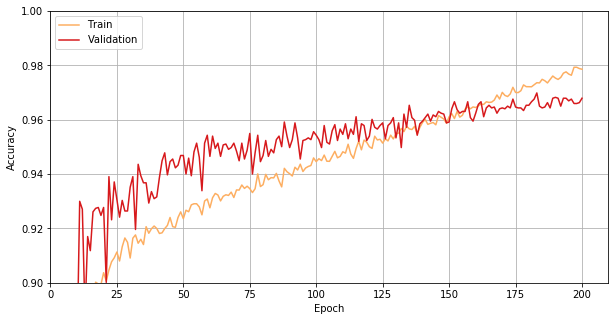

In [39]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.9, 1)
plt.xlim(0)
plt.grid()
plt.show()

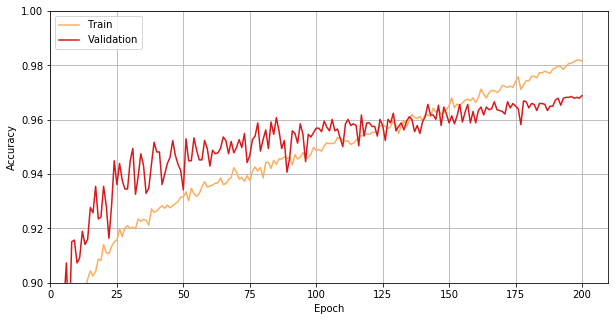

In [17]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.9, 1)
plt.xlim(0)
plt.grid()
plt.show()

In [48]:
collections.Counter(label_index[np.argmax(yu[0], axis=1)])

Counter({'down': 2359,
         'go': 2372,
         'left': 2353,
         'no': 2375,
         'off': 2357,
         'on': 2367,
         'right': 2367,
         'stop': 2380,
         'up': 2375,
         'yes': 2377,
         'silence': 120,
         'unknown': 4072})

In [132]:
def test_data_generator(batch):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            yield fnames, (np.array(imgs) - x_mean) / x_std
    yield fnames, (np.array(imgs) - x_mean) / x_std
    raise StopIteration()

In [79]:
gc.collect()

index = []
results = []
t0 = datetime.datetime.now()
i = 1
b = 128
pnames = []
plabels = []

for fnames, imgs in test_data_generator(b):
#     pred = np.sqrt(models[9].predict(imgs))
#     for u in range(9):
#         pred = pred + np.sqrt(models[u].predict(imgs))
    pred = model.predict(imgs)
    m = np.max(pred, axis=1)
    pred = np.argmax(pred, axis=1)
    pred = [label_index[p] for p in pred]
    index.extend(fnames)
    results.extend(pred)
    pnames.extend(np.asarray(fnames)[m>.99].tolist())
    plabels.extend(np.asarray(pred)[m>.99].tolist())
    delta = datetime.datetime.now() - t0
    clear_output(wait=True)
    print('%.2f%% %.1f seconds left' % (b*i/1585.38, delta.total_seconds()*(158538/b/i-1)))
    i+=1

100.03% -0.3 seconds left


RuntimeError: generator raised StopIteration

In [152]:
gc.collect()

b = 2000
dnames = []
dlabels = []

for fnames, imgs in test_data_generator(b):
#     pred = np.sqrt(models[9].predict(imgs))
#     for u in range(9):
#         pred = pred + np.sqrt(models[u].predict(imgs))
    pred = model.predict(imgs)
    m = np.max(pred, axis=1)
    pred = np.argmax(pred, axis=1)
    pred = [label_index[p] for p in pred]
    dnames.extend(np.asarray(fnames)[m<.3].tolist())
    dlabels.extend(np.asarray(pred)[m<.3].tolist())
    break

In [162]:
dnames[1]

'clip_000dcdd2c.wav'

In [165]:
r,s = wavfile.read(os.path.join('low', 'clip_00e8a3e1c.wav'))

In [153]:
for name in dnames:
    copyfile(os.path.join(test_data_path, name), os.path.join('low', name))

In [130]:
ims = []
rate, samples = wavfile.read(os.path.join('pseudo', 'on', "clip_00c4e1332.wav"))
samples = pad_audio(samples)
resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
_, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
ims.append(specgram)

pred = model.predict((np.array(ims) - x_mean) / x_std)

In [131]:
pred[0]

array([4.5142027e-05, 2.3963228e-05, 2.6731126e-05, 2.9044217e-05,
       2.3458326e-02, 9.7553945e-01, 8.9399451e-05, 1.2088838e-06,
       4.9073034e-05, 3.2448152e-04, 4.0067796e-04, 1.2540844e-05],
      dtype=float32)

In [106]:
pnames.index("clip_0cc03363a.wav")

6379

In [104]:
from shutil import copyfile

for label, name in zip(plabels, pnames):
    copyfile(os.path.join(test_data_path, name), os.path.join('pseudo', label, name))

In [80]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'submission.csv'), index=False)

In [81]:
df['label'].value_counts()

unknown    74535
left       11075
on         10403
up          8364
no          8103
silence     7733
off         6703
right       6686
stop        6422
down        6374
go          6198
yes         5942
Name: label, dtype: int64